In [ ]:
from google.colab import files
uploaded = files.upload()  # selecciona movies_FINAL.csv

Saving movies_FINAL.csv to movies_FINAL (4).csv


# Cargar el CSV


In [ ]:
import pandas as pd, csv, re

def load_csv_robust(path):
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    seps = [",", ";", "|", "\t"]
    last_err = None

    for enc in encodings:
        # intento detectar el separador con Sniffer
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                sample = f.read(65536)
            try:
                guess = csv.Sniffer().sniff(sample, delimiters=";,|\t,").delimiter
                seps = [guess] + [s for s in seps if s != guess]
            except Exception:
                pass
        except Exception as e:
            last_err = e
            continue

        # pruebo leer con varios separadores
        for sep in seps:
            try:
                df = pd.read_csv(
                    path,
                    sep=sep,
                    engine="python",
                    encoding=enc,
                    quotechar='"',
                    escapechar="\\",
                    on_bad_lines="warn",  # si alguna fila viene dañada, la avisa pero no rompe
                )
                print(f"✓ Leído con encoding={enc}, sep={repr(sep)} -> shape {df.shape}")
                return df, enc, sep
            except Exception as e:
                last_err = e
                # sigue probando
    raise last_err

df, enc, sep = load_csv_robust("movies_FINAL.csv")
df.head(3)


✓ Leído con encoding=utf-8, sep=',' -> shape (4998, 27)


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,...,language,country,content_rating,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,budget_filled,gross_filled
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,...,English,USA,PG-13,2009.0,936.0,7.9,1.78,33000.0,237000000.0,760505847.0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,...,English,USA,PG-13,2007.0,5000.0,7.1,2.35,0.0,300000000.0,309404152.0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,...,English,UK,PG-13,2015.0,393.0,6.8,2.35,85000.0,245000000.0,200074175.0


In [ ]:
df.to_csv("movies_FINAL_CLEAN.csv", index=False, encoding="utf-8")

In [ ]:
df['plot_keywords']

,plot_keywords
0,avatar|future|marine|native|paraplegic
1,goddess|marriage ceremony|marriage proposal|pi...
2,bomb|espionage|sequel|spy|terrorist
3,deception|imprisonment|lawlessness|police offi...
4,NaN
...,...
4993,fraud|postal worker|prison|theft|trial
4994,cult|fbi|hideout|prison escape|serial killer
4995,NaN
4996,NaN


# Seleccionar la columna de texto y limpiar plot_keywords

In [ ]:
# Preferimos plot_keywords; si no existe, usamos keywords
text_col = None
for c in ["plot_keywords", "keywords"]:
    if c in df.columns:
        text_col = c
        break

if text_col is None:
    raise ValueError("No se encontró la columna 'plot_keywords' ni 'keywords'.")

import re
def limpiar_kw(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower().strip()
    s = re.sub(r"[|;/]", " ", s)     # separadores -> espacio
    s = s.replace("-", "_")          # conservar multi-palabras
    s = re.sub(r"[^a-z0-9_\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["keywords_clean"] = df[text_col].fillna("").astype(str).apply(limpiar_kw)
df[[text_col, "keywords_clean"]].head(5)

,plot_keywords,keywords_clean
0,avatar|future|marine|native|paraplegic,avatar future marine native paraplegic
1,goddess|marriage ceremony|marriage proposal|pi...,goddess marriage ceremony marriage proposal pi...
2,bomb|espionage|sequel|spy|terrorist,bomb espionage sequel spy terrorist
3,deception|imprisonment|lawlessness|police offi...,deception imprisonment lawlessness police offi...
4,NaN,


In [ ]:
import nltk
from nltk.corpus import stopwords
import string

# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = stopwords.words('english')  # O 'spanish' si tus datos están en español

# Lista personalizada de stopwords que incluye más palabras comunes
custom_stopwords = stop_words + ['by', 'the', 'in', 'on', 'of', 'and', 'to', 'a', 'is', 'for', 'with', 'this']

# Función para eliminar stopwords y normalizar el texto
def remove_stopwords(text):
    if isinstance(text, str):  # Verifica que sea un string
        text = text.lower()  # Convertir a minúsculas
        text = ''.join([char for char in text if char not in string.punctuation])  # Eliminar puntuación
        return ' '.join([word for word in text.split() if word not in custom_stopwords])
    else:
        return ''

# Limpiar la columna de plot_keywords
df['clean_keywords'] = df['plot_keywords'].apply(remove_stopwords)

# Verifica las primeras filas para asegurarte de que se procesó correctamente
print(df[['plot_keywords', 'clean_keywords']].head())

                                       plot_keywords  \
0             avatar|future|marine|native|paraplegic   
1  goddess|marriage ceremony|marriage proposal|pi...   
2                bomb|espionage|sequel|spy|terrorist   
3  deception|imprisonment|lawlessness|police offi...   
5  alien|american civil war|male nipple|mars|prin...   

                                      clean_keywords  
0                 avatarfuturemarinenativeparaplegic  
1  goddessmarriage ceremonymarriage proposalpirat...  
2                    bombespionagesequelspyterrorist  
3  deceptionimprisonmentlawlessnesspolice officer...  
5     alienamerican civil warmale nipplemarsprincess  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Eliminar filas con valores nulos en la columna 'plot_keywords'
df = df.dropna(subset=['plot_keywords'])

# TF-IDF (matriz no negativa para NMF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),            # unigramas y bigramas
    min_df=5,                     # relaja a 2 si tu vocabulario queda chico
    max_df=0.6,
    token_pattern=r"(?u)\b\w[\w_]+\b"  # conserva tokens con guion_bajo
)
X = vectorizer.fit_transform(df["clean_keywords"])

# Si quedó muy pequeño, relajamos filtros
if X.shape[1] < 20:
    vectorizer = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        token_pattern=r"(?u)\b\w[\w_]+\b"
    )
    X = vectorizer.fit_transform(df["clean_keywords"])

features = vectorizer.get_feature_names_out()
features
print("TF-IDF shape:", X.shape)

TF-IDF shape: (4845, 315)


# En la matriz TF-IDF

In [ ]:
import pandas as pd

# Convertir a DataFrame con nombres de features
tfidf_df = pd.DataFrame(X.toarray(), columns=features)

# Mostrar solo las primeras 5 filas y 10 columnas
tfidf_df.iloc[:5, :10]


,12,17th,18th,19th,abandoned,abuse,abusive,action,actor,actor playing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Cada columna corresponde a un término del vocabulario
construido a partir de las plot_keywords. Eso incluye palabras sueltas (avatar, future, love) y también combinaciones de dos palabras (science_fiction, martial_arts), porque usaste ngram_range=(1,2).

- Cada fila representa una película.

- Cada valor numérico es el peso TF-IDF que indica cuánto caracteriza esa palabra (columna) a esa película (fila).





In [ ]:
# Ejemplo: mostrar la fila 0 con los términos que tienen valor > 0
row0 = tfidf_df.iloc[0]
row0_nonzero = row0[row0 > 0]
row0_nonzero


,0


In [ ]:
density = X.nnz / (X.shape[0] * X.shape[1])
print(f"Densidad de la matriz: {density:.4f}")


Densidad de la matriz: 0.0027


Esto indica qué porcentaje de celdas tienen valores distintos de cero (suele ser muy bajo, 1–5%).

# Elegir k (temas) con curva del “codo” y entrenar NMF

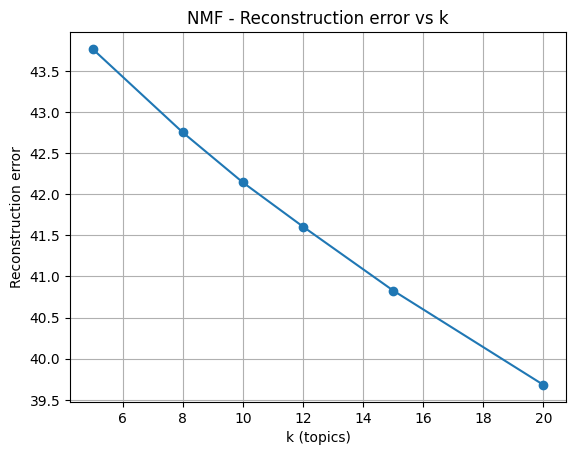

k elegido: 12


In [ ]:
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt

K_LIST = [5, 8, 10, 12, 15, 20]
errors, models = [], []

for k in K_LIST:
    nmf = NMF(n_components=k, init="nndsvd", solver="cd",
              beta_loss="frobenius", max_iter=600, random_state=42)
    W = nmf.fit_transform(X)
    H = nmf.components_
    errors.append(nmf.reconstruction_err_)
    models.append((nmf, W, H))

plt.plot(K_LIST, errors, marker="o")
plt.title("NMF - Reconstruction error vs k")
plt.xlabel("k (topics)")
plt.ylabel("Reconstruction error")
plt.grid(True)
plt.show()

# Heurística simple para elegir k
drops = np.diff(errors)
chosen_k = K_LIST[np.argmin(np.abs(drops / np.array(errors[:-1])))+1] if len(drops) else K_LIST[0]
nmf, W, H = models[K_LIST.index(chosen_k)]
print("k elegido:", chosen_k)

# Interpretar temas (palabras top por tema)




In [ ]:
def top_words(H, feats, topn=12):
    # Aplica el mismo proceso de stop words en la matriz de características
    for i, comp in enumerate(H):
        idx = np.argsort(comp)[:-topn-1:-1]
        print(f"Tema {i}: " + " ".join(feats[idx]))  # Imprime las mejores palabras por tema

# Aplica la función con la matriz H (después de la vectorización y el preprocesamiento)
top_words(H, features, topn=12)

Tema 0: york new new york city york city yorknew york yorknew citynew citynew york manhattan new manhattan york citynew
Tema 1: word title word title name one apostrophe cult titlepunctuation two music opening character
Tema 2: based true based true comic cult tv based comic novel video stage based stage based tv
Tema 3: female directed directed female male lead female frontal camera female nuditymale nudity rear death year
Tema 4: office box box office flopcritically office flopcritically opening animal sex life hunter station artificial
Tema 5: best daughter sex opening night help nudity school relationship schoolhigh school schoolhigh daughter relationship
Tema 6: frontal nuditymale full full frontal frontal nuditymale rear male nudityfemale nudity frontal nudityfemale female frontal nuditymale rear
Tema 7: black comedy woman white school daughter scene hard cop house panties novel
Tema 8: american true african american house civil playing school crime sister trip family actor
Tema 

# Top palabras por tema (gráfico de barras)


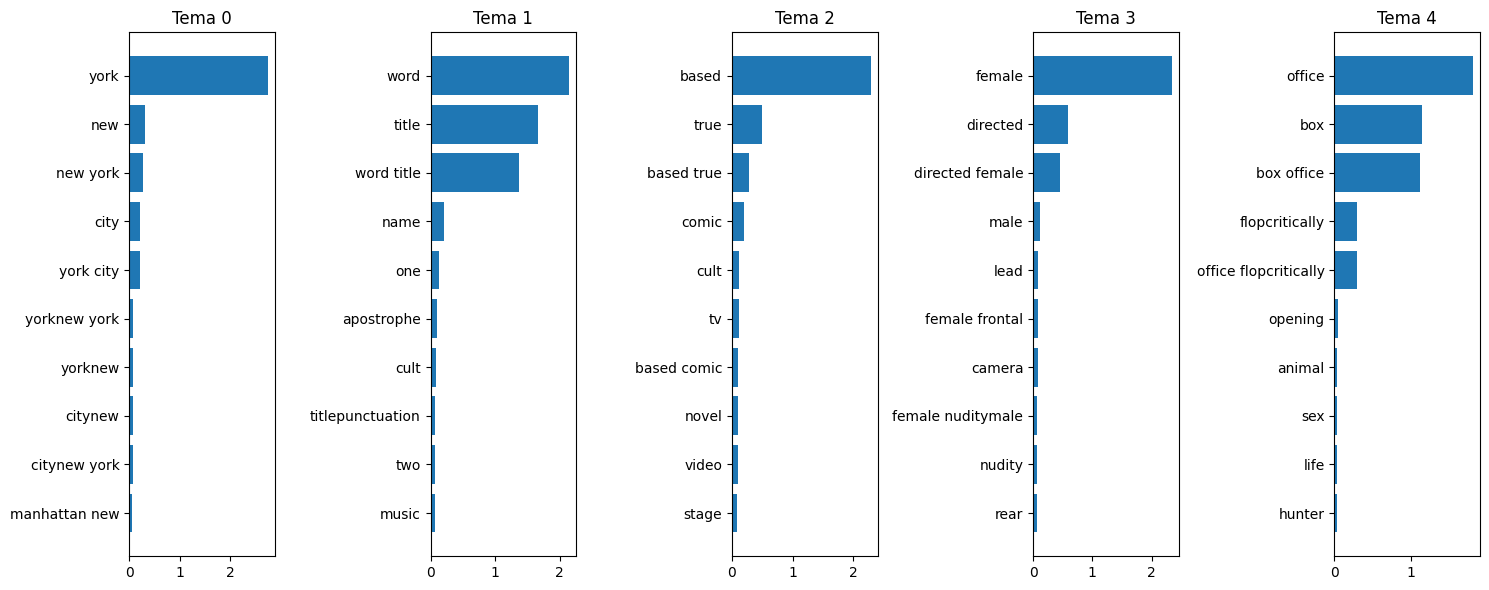

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(H, features, n_top_words=10, n_topics=5):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 6), sharex=False)
    for i, ax in enumerate(axes):
        idx = np.argsort(H[i])[::-1][:n_top_words]
        ax.barh([features[j] for j in idx][::-1], H[i, idx][::-1])
        ax.set_title(f"Tema {i}")
    plt.tight_layout()
    plt.show()

plot_top_words(H, features, n_top_words=10, n_topics=min(5, H.shape[0]))

# Mezcla de temas por película y tema principal

In [ ]:
topics = pd.DataFrame(W, columns=[f"topic_{i}" for i in range(W.shape[1])])

# Normalizamos por fila (suma=1) para interpretar como mezcla
row_sum = topics.sum(axis=1).replace(0, np.nan)
topics = topics.div(row_sum, axis=0).fillna(0.0)

# Añadimos un identificador legible (título)
title_col = "movie_title" if "movie_title" in df.columns else ("title" if "title" in df.columns else df.columns[0])
topics[title_col] = df[title_col]

# Tema predominante
topics["top_topic"] = topics.filter(like="topic_").idxmax(axis=1)
topics.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,movie_title,top_topic
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Avatar,topic_0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Pirates of the Caribbean: At World's End,topic_0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Spectre,topic_0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,The Dark Knight Rises,topic_0
4,0.0,0.0,0.0,0.0,0.000653,0.0,0.0,0.0,0.999347,0.0,0.0,0.0,NaN,topic_8


# Relacionar con éxito: gross / imdb_score

In [ ]:
# Adjuntar métricas si existen
if "gross" in df.columns:
    topics["gross"] = pd.to_numeric(df["gross"], errors="coerce")
if "imdb_score" in df.columns:
    topics["imdb_score"] = pd.to_numeric(df["imdb_score"], errors="coerce")

agg = {"movies": ("top_topic","size")}
if "gross" in topics.columns: agg["mean_gross"] = ("gross","mean")
if "imdb_score" in topics.columns: agg["mean_imdb"] = ("imdb_score","mean")

summary = topics.groupby("top_topic").agg(**agg).reset_index()

# palabras top para hacer legible el resumen
topic_words = []
for i, comp in enumerate(H):
    idx = np.argsort(comp)[::-1][:8]
    topic_words.append(", ".join(features[idx]))
mapping = {f"topic_{i}": w for i, w in enumerate(topic_words)}
summary["topic_words"] = summary["top_topic"].map(mapping)

summary.sort_values("movies", ascending=False)


,top_topic,movies,mean_imdb,topic_words
0,topic_0,2910,6.433462,"york, new, new york, city, york city, yorknew ..."
4,topic_2,279,6.550558,"based, true, based true, comic, cult, tv, base..."
5,topic_3,271,6.610227,"female, directed, directed female, male, lead,..."
8,topic_6,213,6.458824,"frontal, nuditymale, full, full frontal, front..."
3,topic_11,197,6.364921,"african, african american, daughter, name, com..."
11,topic_9,189,6.397297,"car, girl, police, year, sex, body, end, cell"
9,topic_7,179,6.398276,"black, comedy, woman, white, school, daughter,..."
10,topic_8,177,6.443713,"american, true, african american, house, civil..."
1,topic_1,158,6.490968,"word, title, word title, name, one, apostrophe..."
6,topic_4,140,6.391367,"office, box, box office, flopcritically, offic..."


“El modelo NMF nos permitió descubrir temas similares a los géneros oficiales, pero también mezclas interesantes: por ejemplo, un tema donde aparecen keywords de guerra y tecnología, que no corresponde a un único género, sino a un híbrido de acción y ciencia ficción.”

# Temas sobre-representados en el top 25%

In [ ]:
def top_quartile(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return np.quantile(s, 0.75) if not s.empty else np.nan

if "gross" in topics.columns:
    gq = top_quartile(topics["gross"])
    if not np.isnan(gq):
        t_gross = (topics.assign(success = topics["gross"] >= gq)
                   .groupby(["top_topic","success"]).size().unstack(fill_value=0))
        print("\nTópicos vs éxito (top 25% gross):")
        display(t_gross)

if "imdb_score" in topics.columns:
    iq = top_quartile(topics["imdb_score"])
    if not np.isnan(iq):
        t_imdb = (topics.assign(success = topics["imdb_score"] >= iq)
                  .groupby(["top_topic","success"]).size().unstack(fill_value=0))
        print("\nTópicos vs éxito (top 25% IMDB):")
        display(t_imdb)


Tópicos vs éxito (top 25% IMDB):


success,False,True
top_topic,,
topic_0,2137,773
topic_1,111,47
topic_10,61,26
topic_11,153,44
topic_2,195,84
topic_3,176,95
topic_4,110,30
topic_5,27,18
topic_6,154,59


In [ ]:
# Diccionario de temas
topics_dict = pd.DataFrame({
    "topic": list(range(H.shape[0])),
    "top_words": [", ".join(features[np.argsort(H[i])[::-1][:12]]) for i in range(H.shape[0])]
})
topics_dict.to_csv("NMF_topics_dictionary.csv", index=False)

# Pesos por película
topics.to_csv("movies_with_topics_FINAL.csv", index=False)

print("Guardado:\n - NMF_topics_dictionary.csv\n - movies_with_topics_FINAL.csv")


Guardado:
 - NMF_topics_dictionary.csv
 - movies_with_topics_FINAL.csv


# Distribución de películas por tema (gráfico de barras)

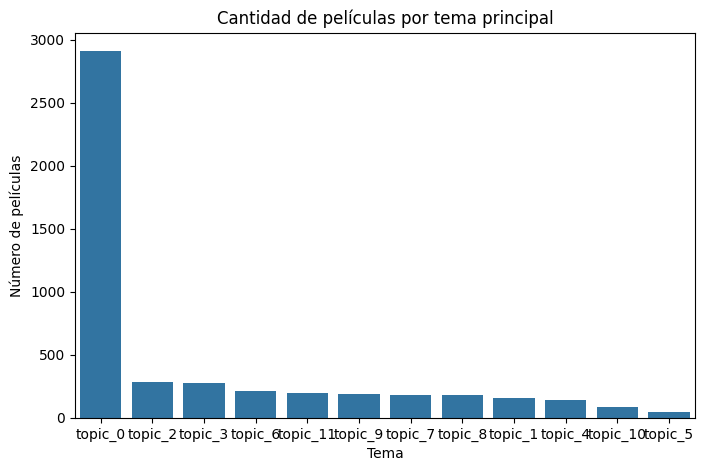

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=topics, x="top_topic", order=topics["top_topic"].value_counts().index)
plt.title("Cantidad de películas por tema principal")
plt.xlabel("Tema")
plt.ylabel("Número de películas")
plt.show()


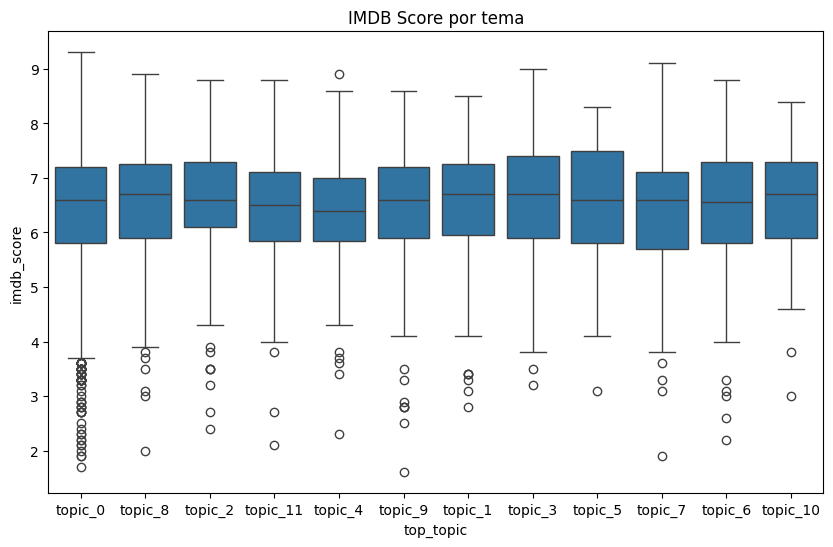

In [ ]:
if "gross" in topics.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=topics, x="top_topic", y="gross")
    plt.title("Recaudación (gross) por tema")
    plt.show()

if "imdb_score" in topics.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=topics, x="top_topic", y="imdb_score")
    plt.title("IMDB Score por tema")
    plt.show()
